In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch

In [3]:
class model_CFG:
    # Embedding
    key_embed_size = 512
    val_embed_size = 256
    embed_size = 768 # Scale By Value
    # Encoder
    dim_input = 768
    n_heads = 8
    hidden_size = 512
    num_inds = 32
    num_outputs = 7
    n_class = 1
    ln=False
    # Training
    lr = 1e-5
    n_epochs = 5
    device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
    regression_weight = 1.0

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import os
import sys
import json
import rich
import math
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

from get_data import train_dataset, test_dataset
from utils import collate_fn_train, collate_fn_test
import networkx as nx
from collections import Counter
from tqdm import tqdm

sys.path.append('/home/karakanaidu/experiment/chip/Code/Models/Set_Transformer/set_transformer')
from modules import MAB, SAB, ISAB, PMA

In [7]:
class pragmas:
    pragmas = ['__PARA__L0', '__PARA__L0_0', 
               '__PARA__L0_1', '__PARA__L0_1_0', 
               '__PARA__L0_2', '__PARA__L0_2_0', 
               '__PARA__L0_3', '__PARA__L0_3_0', 
               '__PARA__L1', '__PARA__L2', '__PARA__L3', '__PARA__L4', '__PARA__L5', '__PARA__L6', 
               '__PARA__L7', '__PARA__L7_0', 
               '__PARA__L8', 
               '__PIPE__L0', '__PIPE__L0_1', '__PIPE__L0_2', '__PIPE__L0_3', 
               '__PIPE__L1', '__PIPE__L2', '__PIPE__L3', '__PIPE__L4', '__PIPE__L5', '__PIPE__L7', 
               '__TILE__L0', '__TILE__L0_1', '__TILE__L0_2', '__TILE__L0_3', 
               '__TILE__L1', '__TILE__L2', '__TILE__L3', '__TILE__L4', '__TILE__L5']
    categorical_space = [
                '__PIPE__L0','__PIPE__L1','__PIPE__L2','__PIPE__L3',
                '__PIPE__L0_1','__PIPE__L0_2','__PIPE__L0_3',
                '__PIPE__L4','__PIPE__L5','__PIPE__L7',
    ]
    integer_space = [
                '__PARA__L0', 
                '__PARA__L0_0', '__PARA__L0_1', '__PARA__L0_1_0', 
                '__PARA__L0_2', '__PARA__L0_2_0', '__PARA__L0_3', '__PARA__L0_3_0', 
                '__PARA__L1', '__PARA__L2', '__PARA__L3', '__PARA__L4', '__PARA__L5', '__PARA__L6', '__PARA__L7', 
                '__PARA__L7_0', '__PARA__L8', 
                '__TILE__L0', '__TILE__L0_1', '__TILE__L0_2', '__TILE__L0_3', 
                '__TILE__L1', '__TILE__L2', '__TILE__L3', '__TILE__L4', '__TILE__L5'
    ]

In [8]:
train_ds = train_dataset(split='train')
val_ds = train_dataset(split='val')
test_ds = test_dataset()

FileNotFoundError: [Errno 2] No such file or directory: './../../Data/train_data/data/designs/v18'

In [49]:
train_dataloader = DataLoader(train_ds, batch_size=1, collate_fn = collate_fn_train)
val_dataloader = DataLoader(val_ds, batch_size=1, shuffle=True, collate_fn = collate_fn_train)
test_dataloader = DataLoader(test_ds, batch_size=1, shuffle=False, collate_fn = collate_fn_test)

In [54]:
class set_transformer(nn.Module):
    def __init__(self):
        super(set_transformer, self).__init__()
        self.enc = nn.Sequential(
                        SAB(model_CFG.dim_input,   model_CFG.hidden_size, model_CFG.n_heads, ln=model_CFG.ln),
                        SAB(model_CFG.hidden_size, model_CFG.hidden_size, model_CFG.n_heads, ln=model_CFG.ln),
                        # SAB(model_CFG.hidden_size, model_CFG.hidden_size, model_CFG.n_heads, ln=model_CFG.ln),
                    )
        self.dec = nn.Sequential(
                        PMA(model_CFG.hidden_size, model_CFG.n_heads, model_CFG.num_outputs, ln=model_CFG.ln),
                        # SAB(model_CFG.hidden_size, model_CFG.hidden_size, model_CFG.n_heads, ln=model_CFG.ln),
                        # SAB(hidden_size, hidden_size, num_heads, ln=ln),
                        nn.Linear(model_CFG.hidden_size, model_CFG.n_class)
                    )

        self.enc = self.enc.to(device=model_CFG.device)
        self.dec = self.dec.to(device=model_CFG.device)
        
        no_of_embeddings = len(pragmas.categorical_space*3 + pragmas.integer_space)
        
        cat_table = {f'{label}_{value}' : self.kaiming_init_embedding(model_CFG.embed_size) for label in pragmas.categorical_space for value in ['','off','flatten']}
        
        reg_table = {label : self.kaiming_init_embedding(model_CFG.key_embed_size) for label in pragmas.integer_space}
        self.reg_value_encoder = nn.ModuleDict({label : nn.Linear(1,model_CFG.val_embed_size) for label in pragmas.integer_space})
        
        self.embeddings = nn.ParameterDict(cat_table | reg_table)
        
        for param in self.parameters():
            param.requires_grad = True
    def kaiming_init_embedding(self, size):
        embedding = torch.empty((size,1), requires_grad=True,device=model_CFG.device)
        nn.init.kaiming_uniform_(embedding, a=math.sqrt(5))  # or use kaiming_normal_
        return embedding

    def forward(self,X):
        embeddings = []
        for key,item in X.items():
            # try:
                if key in pragmas.categorical_space and item in ['off','flatten','']:
                    embeddings.append(self.embeddings[f'{key}_{item}'])
                    
                elif key in pragmas.integer_space:
                    value_embedding = self.reg_value_encoder[key](torch.tensor(item,dtype=torch.float32,device=model_CFG.device).reshape(1,1))

                    embeddings.append(
                        torch.vstack([self.embeddings[key],value_embedding.reshape(-1,1)])
                    )
                    
                else:
                    print(f"Unknown Target {key} value: {item}")
                    raise f"Unknown Target {key} value: {item}"
                    
            # except Exception as ex:
            #     print(ex)
            #     print(f"Unknown Target {key} value: {item}")
# #                 raise f"Unknown Target {key} value: {item}"

        embeddings = torch.stack(embeddings,dim=0).reshape(1,-1,model_CFG.embed_size).to(device=model_CFG.device)
        enc_out = self.enc(embeddings)
        dec_out = self.dec(enc_out)

        pred = torch.squeeze(dec_out, 0)
        pred = pred.reshape(-1)
        return pred

In [61]:
model = set_transformer()

clas_loss_fn = nn.CrossEntropyLoss()
reg_loss_fn = nn.MSELoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=model_CFG.lr)

model = model.to(device=model_CFG.device)
train_epochs = []
val_epochs = []
for epoch in range(model_CFG.n_epochs):
    print(f"Training on {epoch}")
    train_losses = []
    train_cl_losses = []
    train_rg_losses = []
    for i,batch in tqdm(enumerate(train_dataloader),total=len(train_dataloader),desc='Training Loop'):
        optimizer.zero_grad()
        batch_x = batch['X'][0]
        batch_y = batch['y'][0]
        
        ypred = model(batch_x)
        target_classification = torch.tensor(batch_y['valid'],dtype=torch.int64,device=model_CFG.device)
        target_ls = [torch.tensor(v,dtype=torch.float32) for k,v in batch_y.items() if k!='valid']
        target_regression = torch.tensor(target_ls,device=model_CFG.device)
        
        classification_loss = clas_loss_fn(ypred[:2],target_classification)
        reggression_loss = reg_loss_fn(ypred[2:],target_regression)
        

        
        total_loss = model_CFG.regression_weight * reggression_loss + classification_loss
        # print(classification_loss,reggression_loss,total_loss)
        
        total_loss.backward()
        optimizer.step()
        
        total_loss = total_loss.detach().cpu()
        classification_loss = classification_loss.detach().cpu()
        reggression_loss = reggression_loss.detach().cpu()
        train_losses.append(total_loss)
        train_cl_losses.append(classification_loss)
        train_rg_losses.append(reggression_loss)
    train_epochs.append((train_losses,train_cl_losses,train_rg_losses))
    print('Evaluation:-')
    val_losses = []
    val_cl_losses = []
    val_rg_losses = []
    for i,batch in tqdm(enumerate(val_dataloader),total=len(val_dataloader),desc='Training Loop'):

        target_classification = torch.tensor(batch_y['valid'],dtype=torch.int64)
        target_ls = [torch.tensor(v,dtype=torch.float32) for k,v in batch_y.items() if k!='valid']
        target_regression = torch.tensor(target_ls,device=model_CFG.device)
        
        batch_x = batch['X'][0]
        batch_y = batch['y'][0]
        
        with torch.no_grad():
            ypred = model(batch_x)
        
            classification_loss = clas_loss_fn(ypred[:2],target_classification)
            reggression_loss = reg_loss_fn(ypred[2:],target_regression)
        
            total_loss = model_CFG.regression_weight * reggression_loss + classification_loss
            #    print(classification_loss,reggression_loss,total_loss)
        
            total_loss = total_loss.detach().cpu()
            classification_loss = classification_loss.detach().cpu()
            reggression_loss = reggression_loss.detach().cpu()
            val_losses.append(total_loss)
            val_cl_losses.append(classification_loss)
            val_rg_losses.append(reggression_loss)
        # break
    val_epochs.append((val_losses,val_cl_losses,val_rg_losses))
    

Training on 0


Training Loop:   0%|          | 1/33276 [00:00<1:10:35,  7.86it/s]

Training Loop:  76%|███████▌  | 25370/33276 [08:32<02:39, 49.53it/s]


KeyboardInterrupt: 

In [28]:
print(rg_losses[-1])

IndexError: list index out of range

In [67]:
max(enumerate(rg_losses),key=lambda x:x[1])

(5143, tensor(8.4839e+15))

In [68]:
train_ds[5143]

{'X': {'design': {'__PARA__L0': 1,
   '__PARA__L1': 1,
   '__PARA__L2': 32,
   '__PIPE__L0': 'off',
   '__PIPE__L1': 'off',
   '__TILE__L0': 1,
   '__TILE__L1': 8},
  'version': 'v18',
  'graph': <networkx.classes.digraph.DiGraph at 0x72da448a98b0>,
  'kernel_name': 'seidel-2d',
  'src_code': '#pragma ACCEL kernel\n\nvoid kernel_seidel_2d(int tsteps,int n,double A[120][120])\n{\n  int t;\n  int i;\n  int j;\n//#pragma scop\n  \n#pragma ACCEL PIPELINE auto{__PIPE__L0}\n  \n#pragma ACCEL TILE FACTOR=auto{__TILE__L0}\n  \n#pragma ACCEL PARALLEL FACTOR=auto{__PARA__L0}\n  for (t = 0; t <= 39; t++) {\n    \n#pragma ACCEL PIPELINE auto{__PIPE__L1}\n    \n#pragma ACCEL TILE FACTOR=auto{__TILE__L1}\n    \n#pragma ACCEL PARALLEL FACTOR=auto{__PARA__L1}\n    for (i = 1; i <= 118; i++) {\n      \n#pragma ACCEL PARALLEL FACTOR=auto{__PARA__L2}\n      for (j = 1; j <= 118; j++) {\n        A[i][j] = (A[i - 1][j - 1] + A[i - 1][j] + A[i - 1][j + 1] + A[i][j - 1] + A[i][j] + A[i][j + 1] + A[i + 1][j -

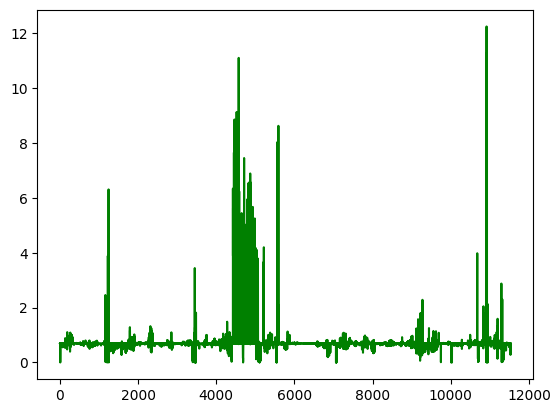

In [70]:

plt.plot(range(len(cl_losses)),cl_losses,color='g')
# plt.plot(range(len(rg_losses)),rg_losses,color='r')

# plt.ylim([0,100])